In [1]:
import pandas as pd
import sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, classification_report

In [2]:
data_set = pd.read_csv('2019-Oct.csv', nrows=1000)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

data_set.dropna(subset=['category_code', 'brand'], inplace=True) # NaN's

grouped_sorted_data = data_set.sort_values(by='user_id').groupby('user_id')

In [3]:
for user_id, group_data in grouped_sorted_data:
    print(f"User ID: {user_id}")
    print(group_data.head())

User ID: 502372361
                  event_time event_type  product_id          category_id                     category_code    brand   price    user_id                          user_session
329  2019-10-01 00:05:13 UTC       view     2700609  2053013563911439225  appliances.kitchen.refrigerators  indesit  310.37  502372361  6f459751-f87b-4eec-8153-bcfafceb352c
305  2019-10-01 00:04:34 UTC       view     2701639  2053013563911439225  appliances.kitchen.refrigerators  indesit  257.15  502372361  6f459751-f87b-4eec-8153-bcfafceb352c
User ID: 512445078
                  event_time event_type  product_id          category_id                      category_code    brand  price    user_id                          user_session
958  2019-10-01 00:16:17 UTC       view     4400495  2053013555095011711  appliances.kitchen.coffee_machine  redmond  195.6  512445078  859edd58-59dd-4b99-bc1d-46591975b73a
User ID: 512521720
                  event_time event_type  product_id          category_id      

In [4]:
features = ["price", "product_id"]


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_set[features])

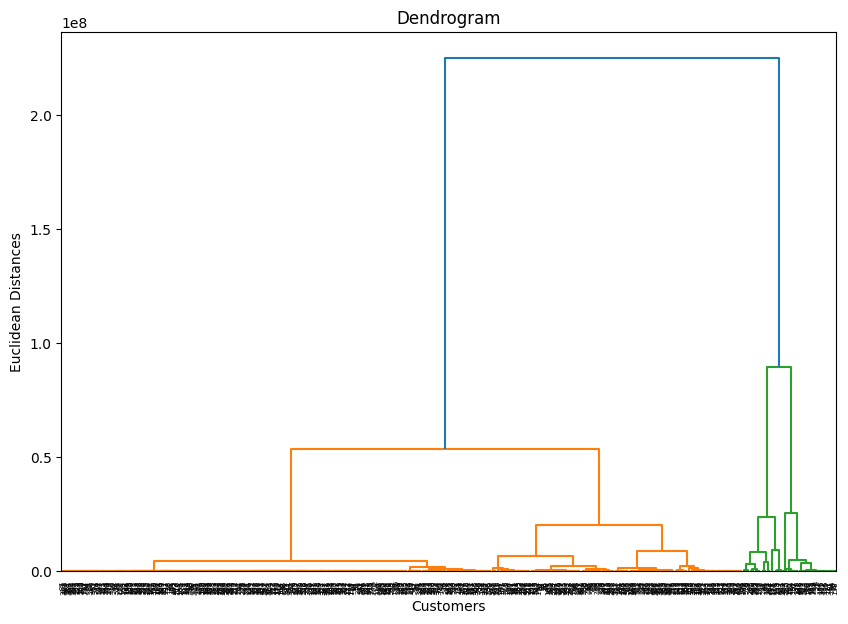

In [5]:
# K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)


cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

data_set["cluster"] = cluster_labels


# print("Number of rows in the dataset:", len(grouped_sorted_data))

plt.figure(figsize=(10, 7))
X = data_set[["price", "product_id"]]
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distances")
plt.show()

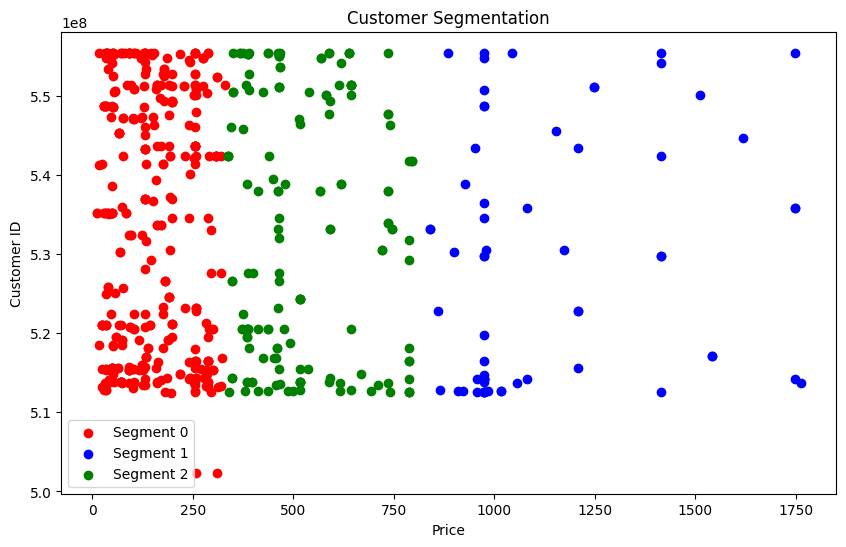

In [6]:
features = ["price"]


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_set[features])

# K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)


data_set["segment"] = kmeans.labels_


colors = {0: 'red', 1: 'blue', 2: 'green'}


plt.figure(figsize=(10, 6))
for segment, color in colors.items():
    segment_data = data_set[data_set['segment'] == segment]
    plt.scatter(segment_data['price'], segment_data['user_id'], color=color, label=f'Segment {segment}')
plt.xlabel('Price')
plt.ylabel('Customer ID')
plt.title('Customer Segmentation')
plt.legend()
plt.show()

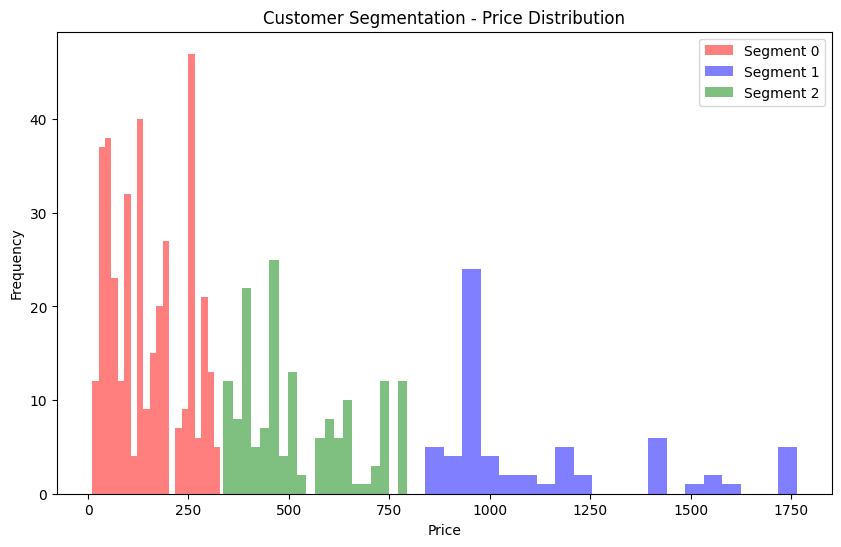

In [7]:
plt.figure(figsize=(10, 6))
for segment, color in colors.items():
    segment_data = data_set[data_set['segment'] == segment]
    plt.hist(segment_data['price'], bins=20, color=color, alpha=0.5, label=f'Segment {segment}')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Customer Segmentation - Price Distribution')
plt.legend()
plt.show()

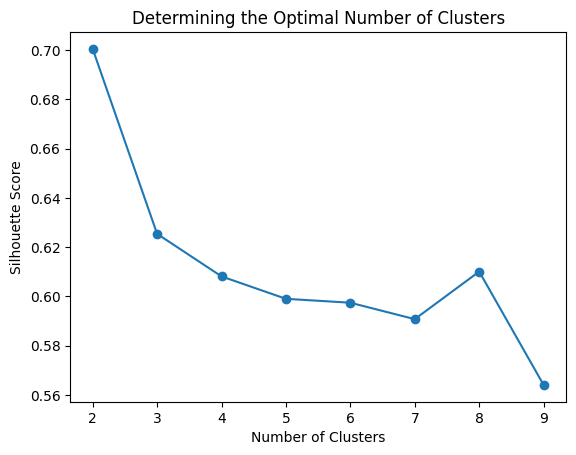

In [8]:
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))


plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Determining the Optimal Number of Clusters')
plt.show()

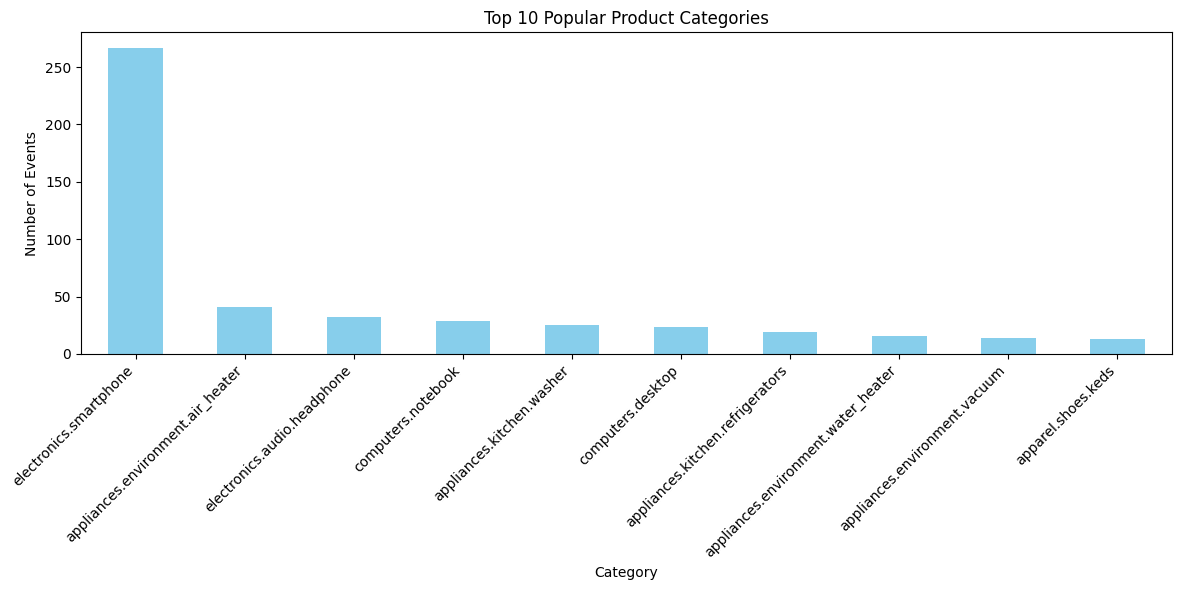

In [9]:
# Analyze the popularity of different product categories
category_popularity = data_set['category_code'].value_counts().head(10)

# Plot the results
plt.figure(figsize=(12, 6))
category_popularity.plot(kind='bar', color='skyblue')
plt.title('Top 10 Popular Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

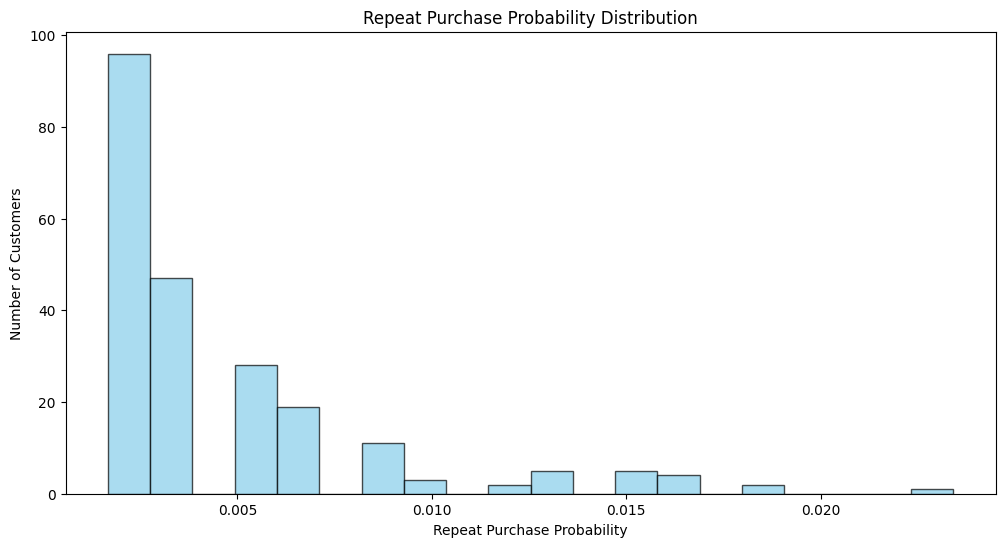

In [10]:
#Müşteri sadakati analizi için gerekli verileri hazırla
customer_data = data_set.groupby('user_id').agg({'event_time': 'count', 'price': 'sum'}).reset_index()
customer_data.columns = ['user_id', 'total_transactions', 'total_spent']

# Tekrarlayan alışveriş yapma olasılığını hesapla
customer_data['repeat_probability'] = customer_data['total_transactions'] / customer_data['total_transactions'].sum()

# Analiz sonuçlarını görselleştir
plt.figure(figsize=(12, 6))
plt.hist(customer_data['repeat_probability'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Repeat Purchase Probability')
plt.ylabel('Number of Customers')
plt.title('Repeat Purchase Probability Distribution')
plt.show()

In [11]:
# Müşteri bazında toplam harcamaları hesapla
customer_spending = data_set.groupby('user_id')['price'].sum().reset_index()

# En çok harcama yapan müşteriyi bul
top_customer = customer_spending.loc[customer_spending['price'].idxmax()]

print("En çok harcama yapan müşteri ID:", top_customer['user_id'])
print("Toplam harcama miktarı:", top_customer['price'])

En çok harcama yapan müşteri ID: 514218020.0
Toplam harcama miktarı: 9103.53


In [12]:
# Random Forest
data_set = data_set.dropna()
X = data_set[['product_id', 'category_id', 'price']]
y = data_set['user_id']
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)
print("denemeeeeeee:",classification_report(y_test, y_pred, zero_division=1))

denemeeeeeee:               precision    recall  f1-score   support

   512533331       1.00      0.00      0.00         1
   512539408       1.00      0.00      0.00         1
   512602434       0.00      1.00      0.00         0
   512723795       1.00      0.00      0.00         1
   512742880       1.00      0.50      0.67         2
   512796782       0.00      0.00      0.00         1
   512800119       1.00      0.00      0.00         1
   513026356       0.00      1.00      0.00         0
   513231972       0.00      1.00      0.00         0
   513413322       1.00      0.00      0.00         1
   513659224       0.00      1.00      0.00         0
   513754510       1.00      0.00      0.00         1
   513758741       1.00      0.00      0.00         1
   513781008       1.00      0.00      0.00         1
   513840435       1.00      1.00      1.00         1
   513881159       1.00      1.00      1.00         3
   514080443       0.00      1.00      0.00         0
   514218020 

In [13]:
# Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)
print("deneme bayesss",classification_report(y_test, y_pred, zero_division=1))

deneme bayesss               precision    recall  f1-score   support

   512521720       0.00      1.00      0.00         0
   512533331       0.00      0.00      0.00         1
   512539408       1.00      0.00      0.00         1
   512558158       0.00      1.00      0.00         0
   512723795       1.00      0.00      0.00         1
   512742880       0.50      0.50      0.50         2
   512796782       0.00      0.00      0.00         1
   512800119       0.50      1.00      0.67         1
   513205415       0.00      1.00      0.00         0
   513347345       0.00      1.00      0.00         0
   513413322       1.00      0.00      0.00         1
   513614895       0.00      1.00      0.00         0
   513754510       1.00      0.00      0.00         1
   513758741       1.00      0.00      0.00         1
   513781008       0.00      0.00      0.00         1
   513840435       1.00      1.00      1.00         1
   513881159       0.50      0.33      0.40         3
   514218020

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

Accuracy: 0.25
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

   512521720       0.00      0.00      0.00         0
   512533331       0.00      0.00      0.00         1
   512539408       0.00      0.00      0.00         1
   512602434       0.00      0.00      0.00         0
   512723795       0.00      0.00      0.00         1
   512742880       0.00      0.00      0.00         2
   512796782       0.00      0.00      0.00         1
   512800119       0.00      0.00      0.00         1
   513026356       0.00      0.00      0.00         0
   513347345       0.00      0.00      0.00         0
   513413322       0.00      0.00      0.00         1
   513457407       0.00      0.00      0.00         0
   513672084       0.00      0.00      0.00         0
   513754510       0.00      0.00      0.00         1
   513758741 

C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

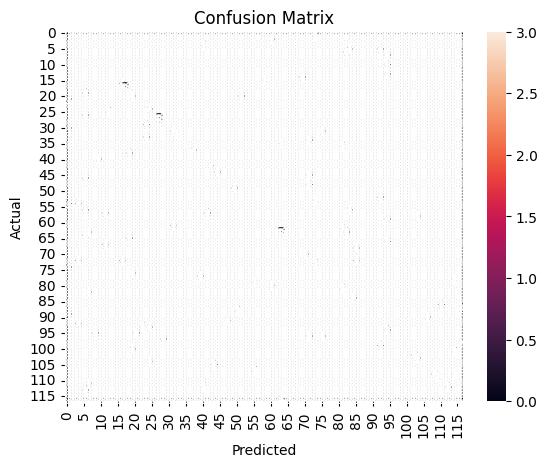

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Seg

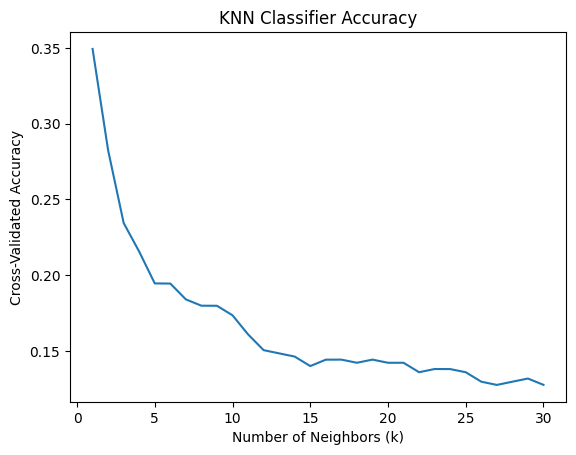

Optimal number of neighbors: 1
Optimal Accuracy: 0.3333333333333333
Optimal Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Optimal Classification Report:
              precision    recall  f1-score   support

   512521720       0.00      0.00      0.00         0
   512533331       0.00      0.00      0.00         1
   512539408       0.00      0.00      0.00         1
   512723795       0.00      0.00      0.00         1
   512742880       0.00      0.00      0.00         2
   512796782       0.00      0.00      0.00         1
   512800119       0.00      0.00      0.00         1
   513231972       0.00      0.00      0.00         0
   513413322       0.00      0.00      0.00         1
   513659224       0.00      0.00      0.00         0
   513754510       0.00      0.00      0.00         1
   513758741       0.00      0.00      0.00         1
   513781008       0.00      0.00      0.00         

C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sipal\OneDrive\Masaüstü\Team11_Customer_Segmentation\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

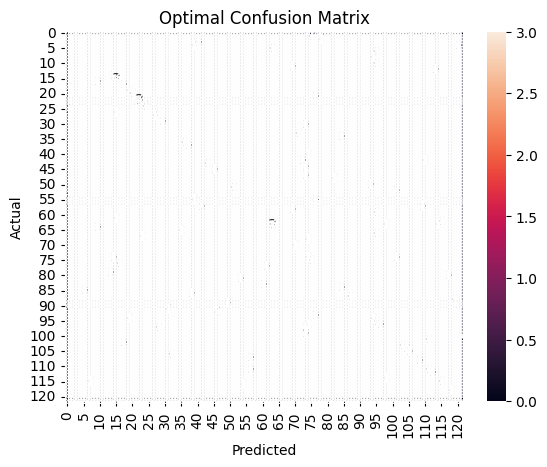

In [17]:
from sklearn.model_selection import cross_val_score

# Find the optimal number of neighbors
accuracy_list = []

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    accuracy_list.append(scores.mean())

# Plot accuracy vs. number of neighbors
plt.plot(range(1, 31), accuracy_list)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Classifier Accuracy')
plt.show()

# Choose the k with the highest accuracy
optimal_k = accuracy_list.index(max(accuracy_list)) + 1
print(f'Optimal number of neighbors: {optimal_k}')

# Retrain the model with optimal k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_optimal = knn_optimal.predict(X_test)

# Re-evaluate the model
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f'Optimal Accuracy: {accuracy_optimal}')

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print('Optimal Confusion Matrix:')
print(conf_matrix_optimal)

class_report_optimal = classification_report(y_test, y_pred_optimal)
print('Optimal Classification Report:')
print(class_report_optimal)

sns.heatmap(conf_matrix_optimal, annot=True, fmt='d')
plt.title('Optimal Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
